### Самостоятельная работа по главе 8 "Механизмы статистического вывода"

In [14]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from theano import tensor as tt

sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext watermark
%watermark --iversions

numpy     : 1.19.2
theano    : 1.0.11
seaborn   : 0.11.1
matplotlib: 3.3.3
scipy     : 1.5.2
pandas    : 1.1.4
pymc3     : 3.10.0
arviz     : 0.11.1



Task 1.

---

Используйте метод грид-вычислений с другими априорными распределениями, например попробуйте варианты 

`prior = (grid <= 0.5).astype(int)` или `prior = abs(grid - 0.5)` 

или сами придумайте и определите какие-нибудь экзотические априорные распределения. Поэкспериментируйте с другими данными, например с увеличением общего объема данных или с большей или меньшей четностью, относящейся к числу наблюдаемых выпадений орлов при подбрасывании монеты.

In [3]:
def posterior_grid(prior_func, grid_points=50, heads=6, tails=9):
    """
    A grid implementation for the coin-flipping problem
    """
    # Define your grid
    grid = np.linspace(0, 1, grid_points)
    
    # Prior
    prior = prior_func(grid)
    
    # Probability mass function
    likelihood = stats.binom.pmf(heads, heads+tails, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    
    return grid, posterior

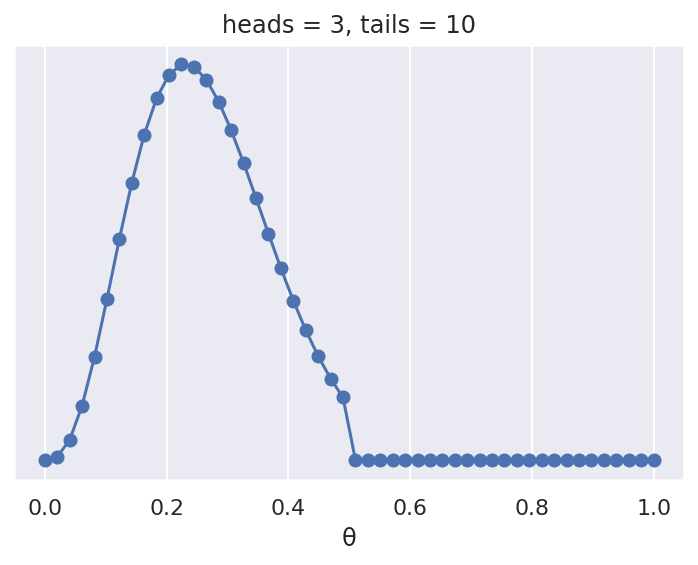

In [4]:
data = np.repeat([0, 1], (10, 3))
points = 50
h = data.sum()
t = len(data) - h

prior_func = lambda x: (x <= 0.5).astype(int)

grid, posterior = posterior_grid(prior_func, points, h, t)

plt.plot(grid, posterior, 'o-')
plt.title(f'heads = {h}, tails = {t}')
plt.yticks([])
plt.xlabel('θ');

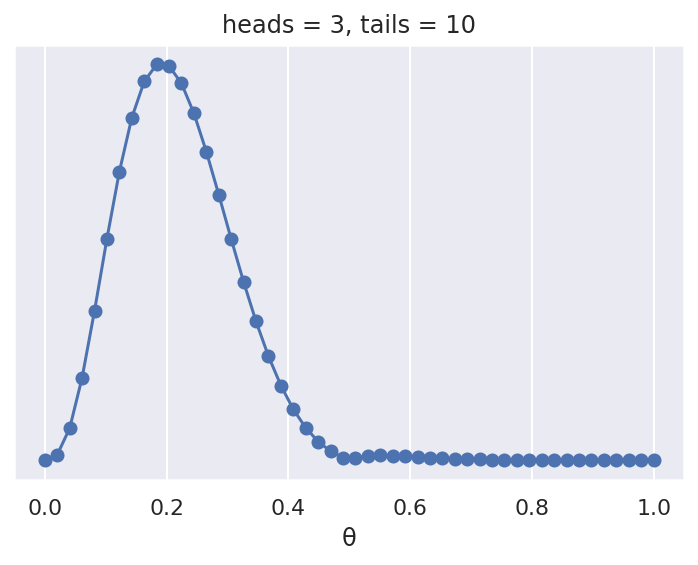

In [5]:
data = np.repeat([0, 1], (10, 3))
points = 50
h = data.sum()
t = len(data) - h

prior_func = lambda x: abs(x - 0.5)

grid, posterior = posterior_grid(prior_func, points, h, t)

plt.plot(grid, posterior, 'o-')
plt.title(f'heads = {h}, tails = {t}')
plt.yticks([])
plt.xlabel('θ');

Task 2.

---

В коде вычисления оценки числа $\pi$ сохраните значение N неизменным и выполните этот код еще несколько раз. 

Обратите внимание на различие результатов из-за использования случайных чисел, но при этом ошибки (погрешности) имеют приблизительно один и тот же порядок (проверьте и убедитесь в этом). 

Можете ли вы сформулировать интуитивно обоснованное предположение о том, как связаны друг с другом общее количество точек N и ошибка (погрешность) вычислений? 

Для более качественной оценки, возможно, потребуется изменить код, чтобы вычислить оценку как функцию от $N$. Новый код также можно выполнить несколько раз без изменения N и вычислить среднее значение ошибки (погрешности) и ее стандартное отклонение. Полученные результаты можно представить в виде диаграммы с помощью функции `plt.errorbar()` из библиотеки matplotlib. Попробуйте использовать множество значений $N$, например 100, 1000, 10000, то есть с изменением величины на порядок или почти на порядок.

Учебный пример - оцена числа $\pi$:

1. Генерация N случайных точек на квадрате со стороной 2R
2. Вписывание окружности радиуса R в квадрат, подсчитать число точек, попавших в окужность $N_{in}$.
3. Получается:\
   Вписанная окружность: $S_{square}=(2R)^2$\
   Квадрат:              $S_{circle}=\pi R^2$\
   Отношение площадей: $\frac{S_{circle}}{S_{square}} = \frac{\pi R^2}{4R^2} = \frac{\pi}{4}$
   
   Значит, нужно оценить соотношение площадей (в нашем случае - реализацией точек на площадях) с коэффициентом:\
   $$\hat{\pi}=4\frac{N_{in}}{N}$$

Замечания:
1. Площади круга и квадрата пропорциональны количеству точек внутри окружности и общему количеству точек $N$ соответственно.
2. Известно, что любая точка находится внутри окружности, если выполняется: $\sqrt{x^2+y^2} \le R$

In [64]:
def sample_points(n):
    return np.random.uniform(-1, 1, size=(2, n))
    
def evaluate_pi(n):
    x, y = sample_points(n)
    inside = (x**2 + y**2) <= 1
    outside = np.invert(inside)
    
    pi = inside.sum()*4/n
    error = abs((pi - np.pi) / pi) * 100
    return pi, error

def get_evals(n_evals, n):
    pi_list = []
    error_list = []
    for i in range(n_evals):
        pi, error= evaluate_pi(n=n)
        pi_list.append(pi)
        error_list.append(error)
    return pi_list, error_list

In [67]:
ns = np.arange(100, 100000, 100)
n_evals = 100

x = []
y = []
yerr = []

for n in tqdm.notebook.tqdm(ns, leave=True):
    pi_list, error_list = get_evals(n_evals, n)
    y.append(np.mean(pi_list))
    x.append(n)
    
    err_mean = np.mean(error_list)
    err_std = np.std(error_list)
    yerr.append([err_mean-err_std, err_mean+err_std])

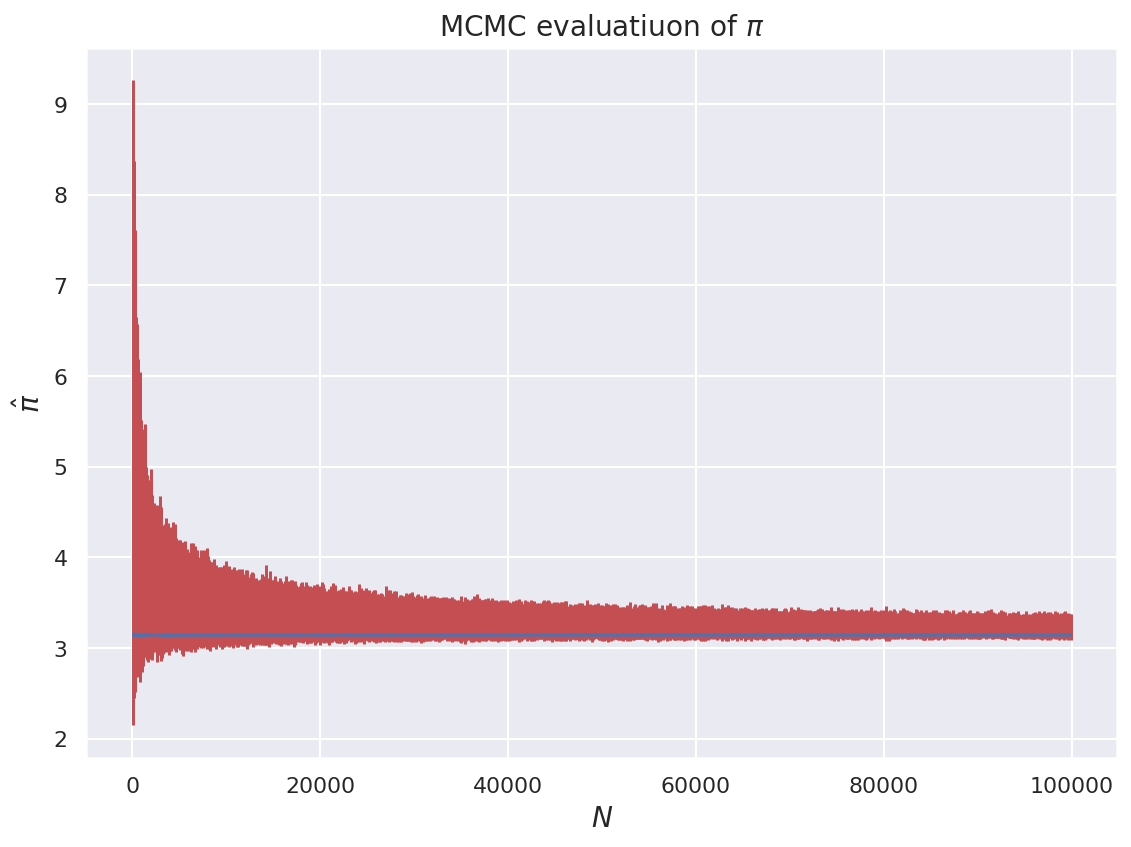

In [71]:
fig = plt.figure(figsize=(8,6))
plt.errorbar(x=x, y=y, yerr=np.array(yerr).T,  label='MCMC for $\pi$ evaluation', ecolor='r')
plt.ylabel("$\hat{\pi}$", fontsize=14)
plt.xlabel("$N$", fontsize=14)

plt.title('MCMC evaluatiuon of $\pi$', fontsize=14)
plt.tight_layout()
plt.show()

В данной задаче, вероятно, погрешность связана с тем, сколько точек будут условно описывать площади квадрата и вписанного в него круга. Чем больше точек будет сгенерировано, тем более плотно они будут покрывать заданное пространство и тем точнее будут аппроксимировать площади геометрических фигур, соотношение площадей которых дает оценку $\pi$.

Task 3.

---


Измените аргумент функции `func`, передаваемой в функцию `metropolis`. Попробуйте воспользоваться значениями априорного распределения из главы 1. Сравните этот код с методом грид-вычислений. Какая часть должна быть изменена, чтобы можно было использовать этот код для решения задачи байесовского статистического вывода?

In [73]:
def metropolis(func, draws=10000):
    """A very simple Metropolis implementation"""
    trace = np.zeros(draws)
    old_x = 0.5 # func.mean()
    old_prob = func.pdf(old_x)
    
    delta = np.random.normal(0, 0.5, draws)
    for i in range(draws):
        new_x = old_x + delta[i]
        new_prob = func.pdf(new_x)
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random():
            trace[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            trace[i] = old_x
    return trace

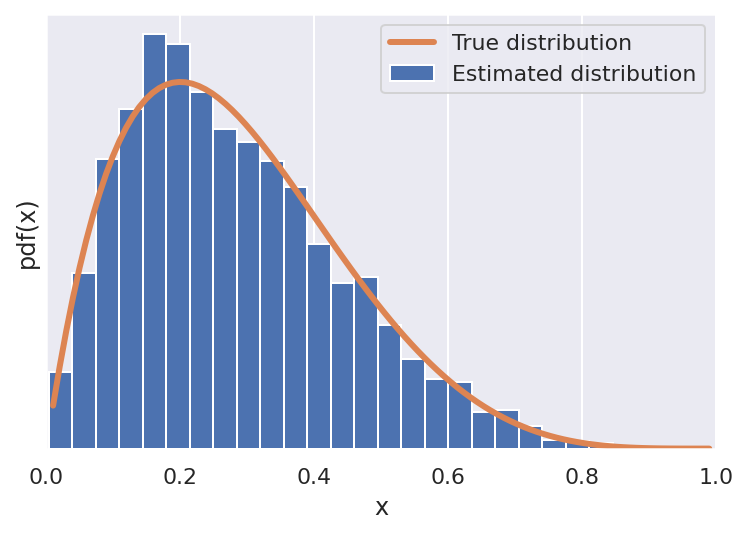

In [74]:
np.random.seed(3)

func = stats.beta(2, 5)
trace = metropolis(func=func)

x = np.linspace(0.01, .99, 100)
y = func.pdf(x)

plt.xlim(0, 1)
plt.plot(x, y, 'C1-', lw=3, label='True distribution')
plt.hist(trace[trace > 0], bins=25, density=True, label='Estimated distribution')

plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.yticks([])
plt.legend()
plt.show()

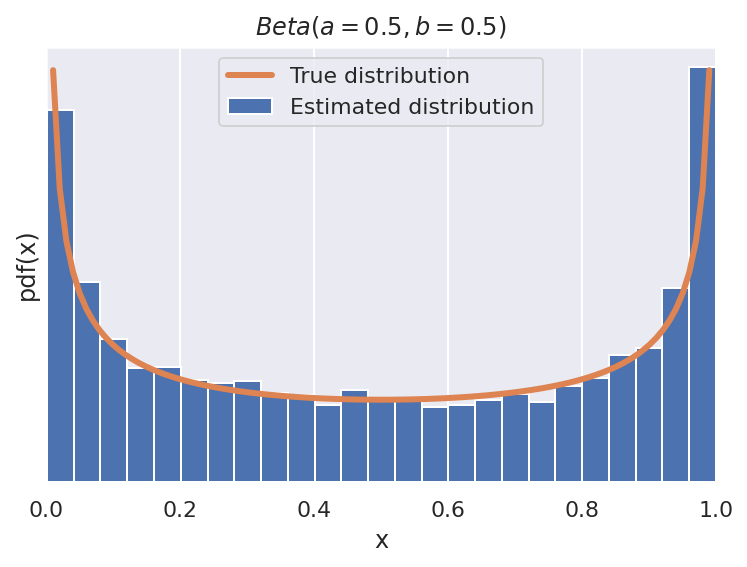

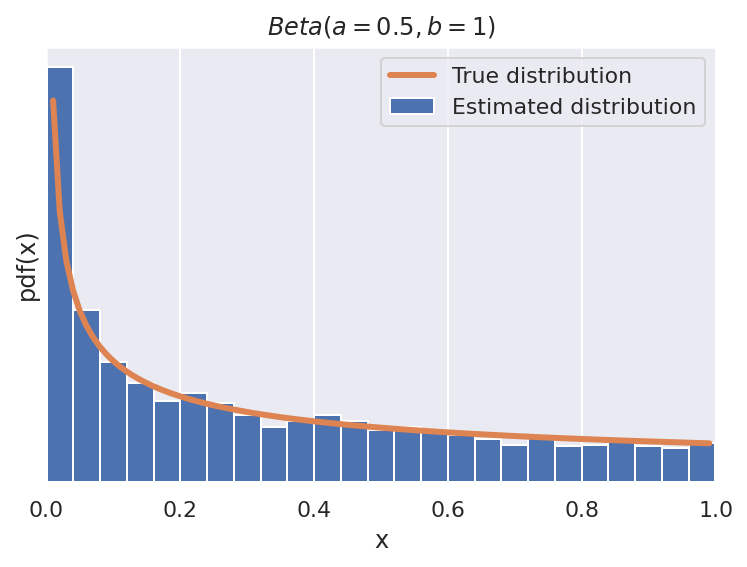

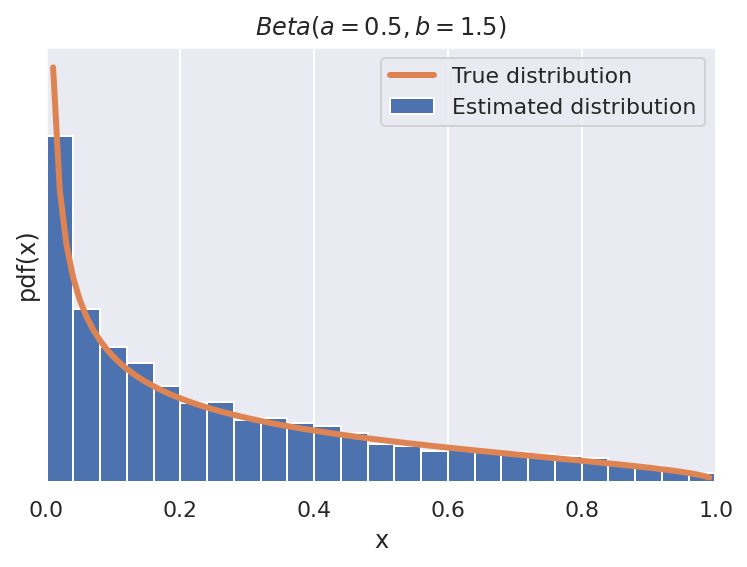

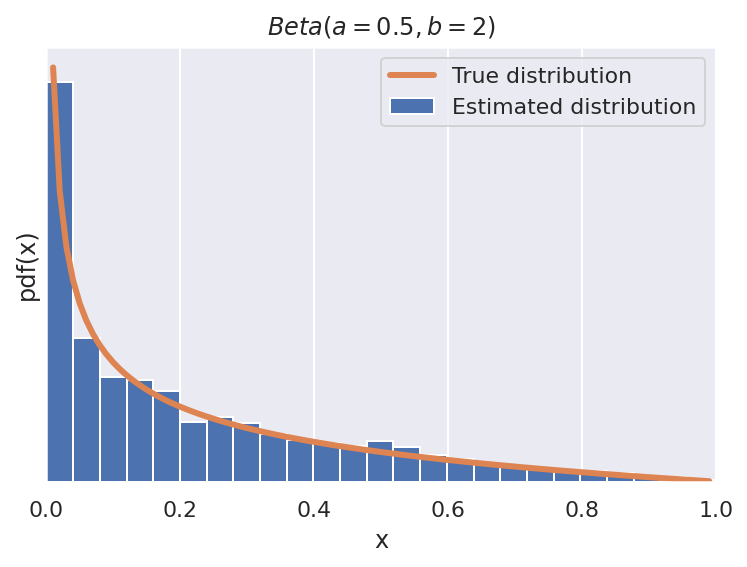

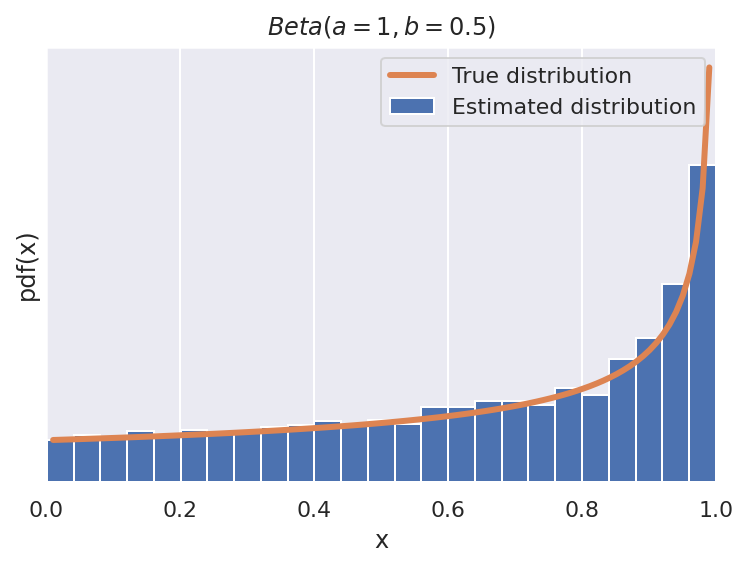

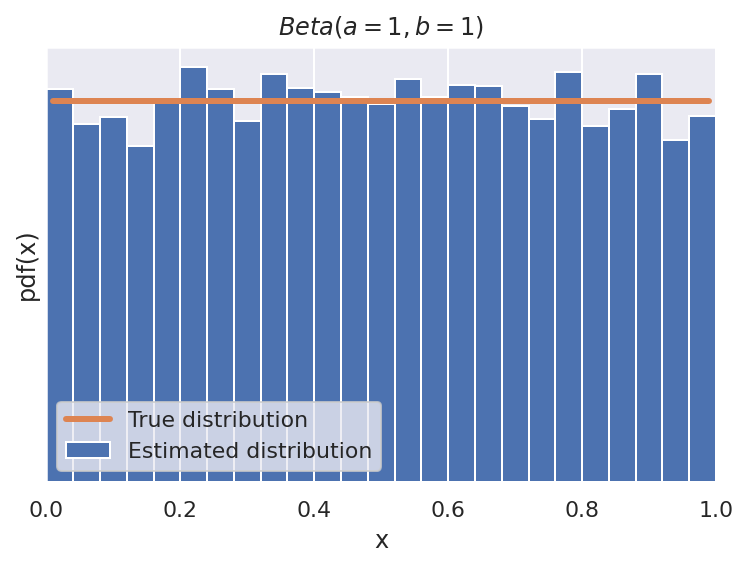

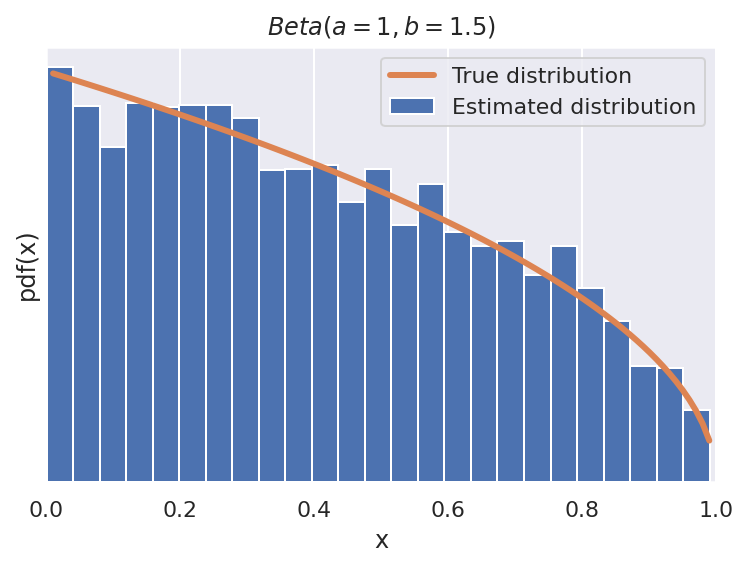

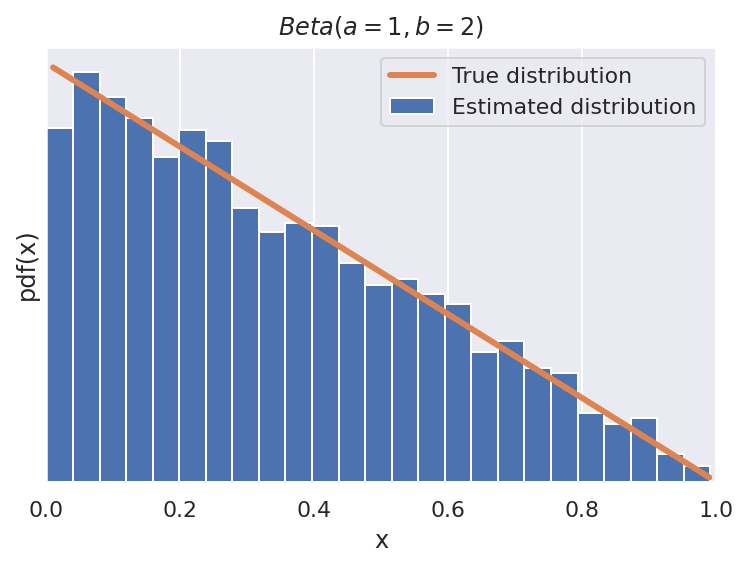

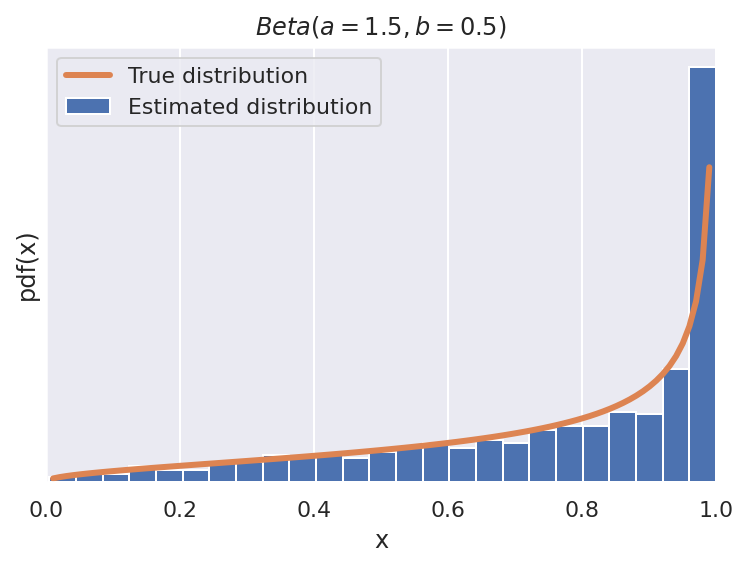

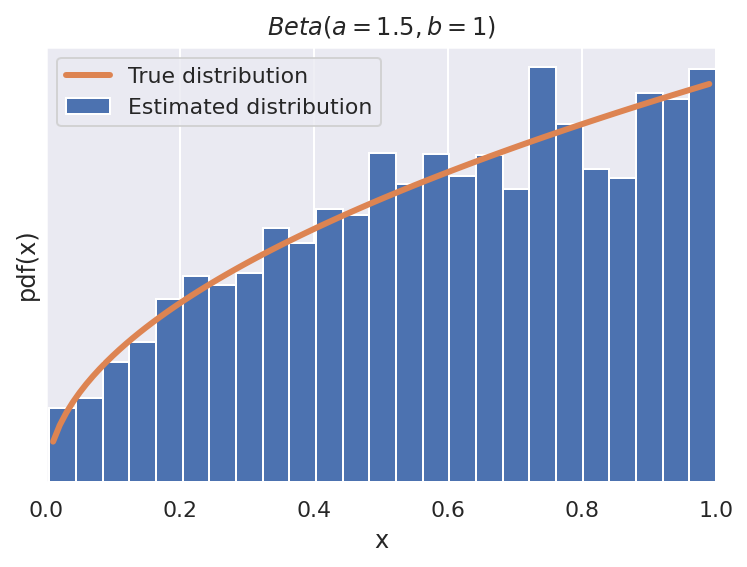

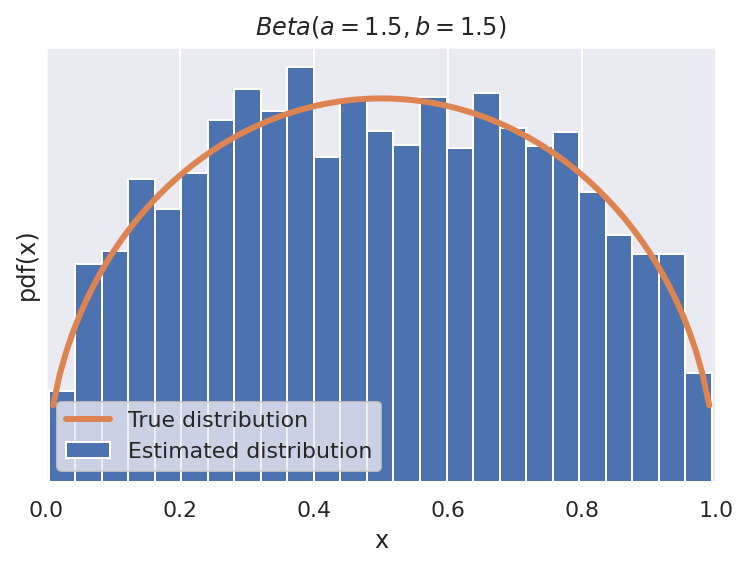

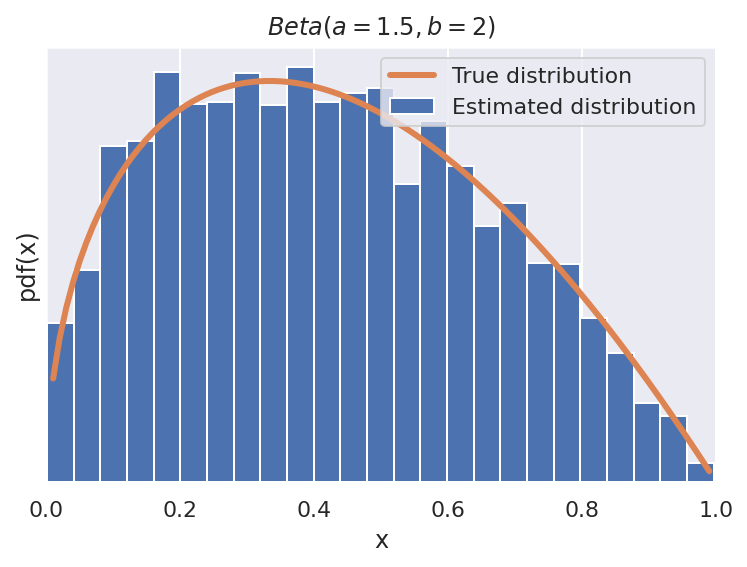

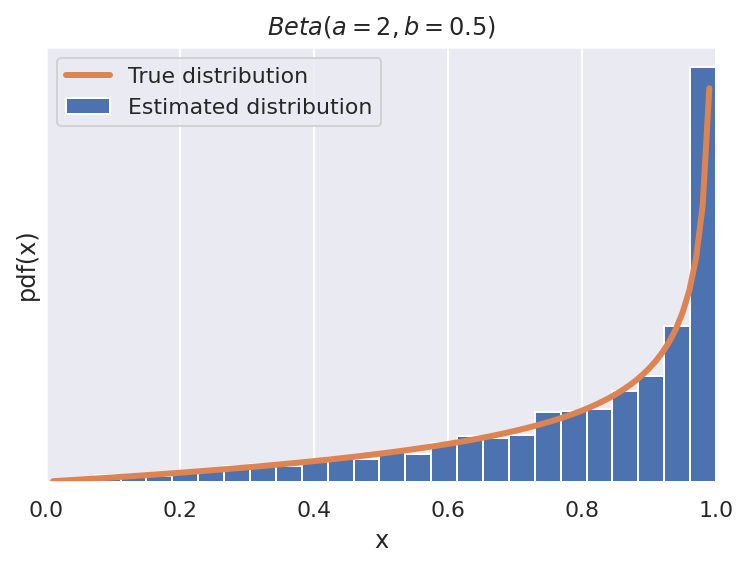

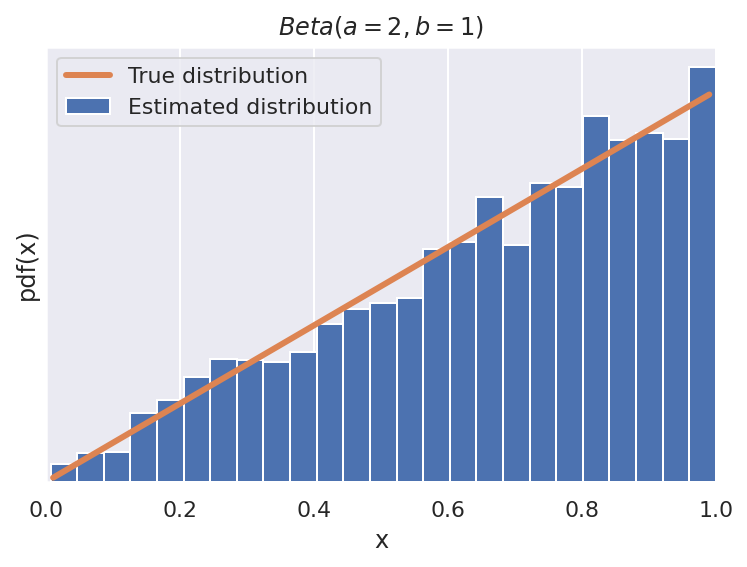

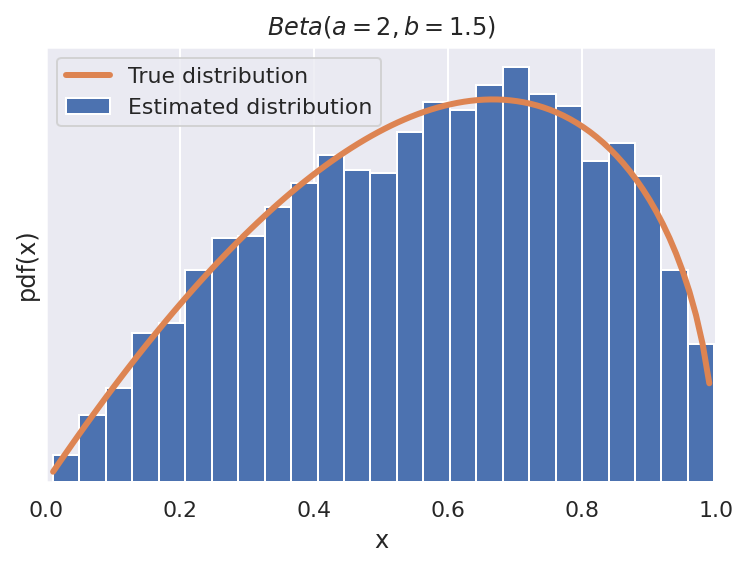

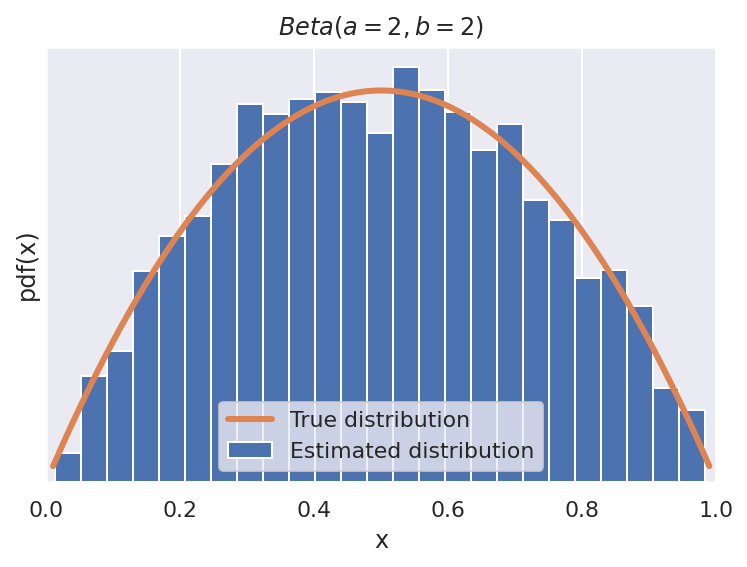

In [78]:
params = [0.5, 1, 1.5, 2]
np.random.seed(3)

for a in params:
    for b in params:

        func = stats.beta(a, b)
        trace = metropolis(func=func)

        x = np.linspace(0.01, .99, 100)
        y = func.pdf(x)
        
        fig = plt.figure(figsize=(6,4))
        plt.xlim(0, 1)
        plt.plot(x, y, 'C1-', lw=3, label='True distribution')
        plt.hist(trace[trace > 0], bins=25, density=True, label='Estimated distribution')

        plt.xlabel('x')
        plt.ylabel('pdf(x)')
        plt.yticks([])
        plt.legend()
        plt.title(f"$Beta(a={a}, b={b})$")
        
        plt.show()

In [441]:
def posterior_grid(prior_func, grid_points=50, heads=6, tails=9):
    """
    A grid implementation for the coin-flipping problem
    """
    # Define your grid
    grid = np.linspace(0, 1, grid_points)
    # Prior
    prior = prior_func.pdf(grid)
    # Probability mass function
    likelihood = stats.binom.pmf(heads, heads+tails, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return grid, posterior

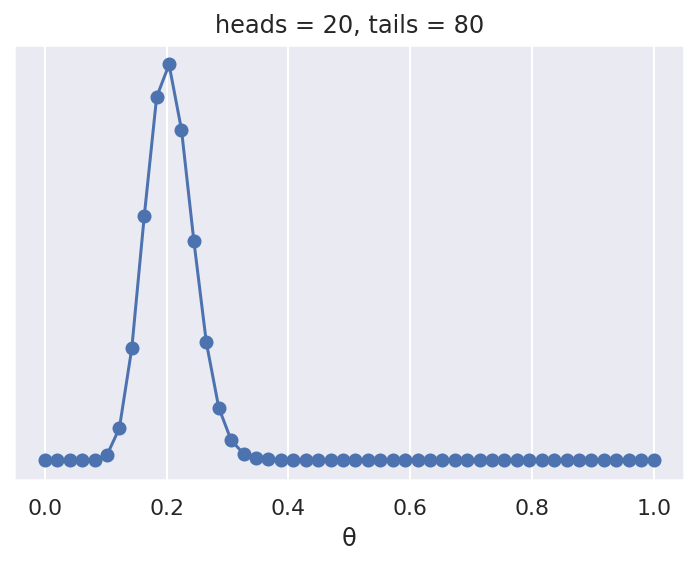

In [442]:
data = np.repeat([0, 1], (80, 20))

points = 50
h = data.sum()
t = len(data) - h
prior_func = stats.beta(2, 5)

grid, posterior = posterior_grid(prior_func, points, h, t)

plt.plot(grid, posterior, 'o-')
plt.title(f'heads = {h}, tails = {t}')
plt.yticks([])
plt.xlabel('θ')
plt.show()

Для решения задачи байесовского статистического вывода на основе `metropolis` необходимо добавить функцию правдоподобия и настроить выбор точек перехода с учетом соотношения произведений правдоподобия и априорной вероятности.

Имплементируем MH для coin flipping:

In [455]:
def mcmc_metropolis(data, prior_func, likelihood_func, accept_distr, 
                    transition_kernel, draws=10000, burn_in=1000, verbose=False):
    """Simple Metropolis implementation for coin flipping model
    
       data:              observed data
       prior_func:        prior probability
       likelihood_func:   likelihood
       accept_distr:      acceptance distribution
       transition_kernel: kernel which defines the way parameter space will be examined
       draws:             number of MCMC samples
       burn_in:           number of first sample portion to drop
       verbose:           print detailed info about sampling
    
    """
    
    heads = sum(data)
    n_obs = len(data)
    
    trace = np.zeros(draws)
    delta = transition_kernel(draws)
    current_param = 0.5
    
    # Old parameter value
    old_param = current_param
    
    for i in tqdm.notebook.tqdm(range(draws), total=draws, leave=True):
        
        # Make a transition
        new_param = min(1, max(0, old_param + delta[i]))
        
        # Old prior probability value
        p_old = prior_func.pdf(old_param)
        # Get prior probability for a new param
        p_new = prior_func.pdf(new_param)
        
        # Old likelihood value
        likelihood_old = likelihood_func(heads, n_obs, old_param)
        # Get likelihood value for a new param
        likelihood_new = likelihood_func(heads, n_obs, new_param)
     
        # Get acceptance ratio
        p_current = p_old*likelihood_old
        p_proposal = p_new*likelihood_new
        accept_ratio = min(1, p_proposal/p_current)
        
        r = accept_distr()
        # Accept new transition or not
        if accept_ratio > r:
            trace[i] = new_param
            old_param = new_param
            p_old = p_new
        else:
            trace[i] = old_param
            
        if verbose:
            print('\n\n')
            print(f'Step: {i}')
            print(f"Observations: {n_obs} Heads: {heads}")
            print(f'Theta old: {old_param}\t Theta new: {new_param}')
            print(f'Pior p old: {p_old}\t Pior p new: {p_new}')
            print(f'Lh old: {likelihood_old}\t Lh new: {likelihood_new}')
            print(f'Ratio {accept_ratio} \t R: {r}')
            
    return trace[burn_in:]

In [456]:
data = np.repeat([0, 1], (80, 20))
data

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [457]:
trace = mcmc_metropolis(data=data,
                        prior_func=stats.beta(2, 5), 
                        likelihood_func=stats.binom.pmf,
                        accept_distr = stats.uniform(0, 1).rvs, # stats.uniform(0, 1).rvs(), np.random.random
                        transition_kernel=lambda draws: np.random.normal(0, 0.01, draws), 
                        draws=5000,
                        burn_in=100,
                        verbose=False
                       )

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


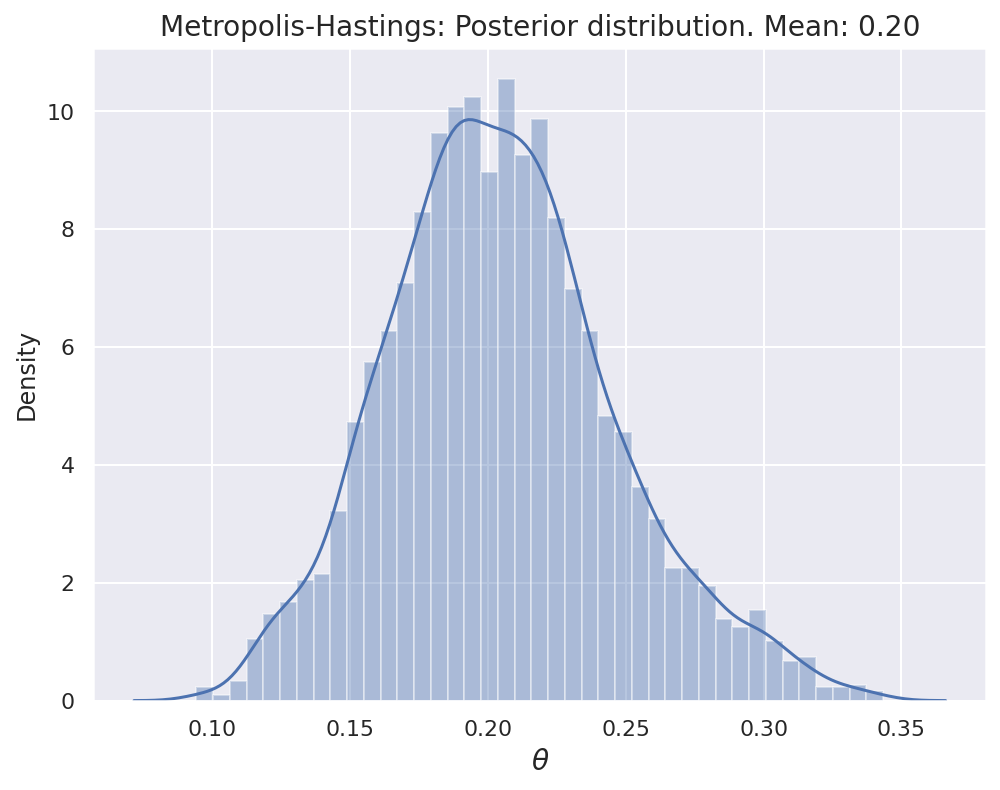

In [458]:
fig = plt.figure(figsize=(8,6))
sns.distplot(trace)

plt.title('Metropolis-Hastings: Posterior distribution. Mean: %.2f' % np.mean(trace), fontsize=14)
plt.xlabel(r"$\theta$", fontsize=14)
plt.show()

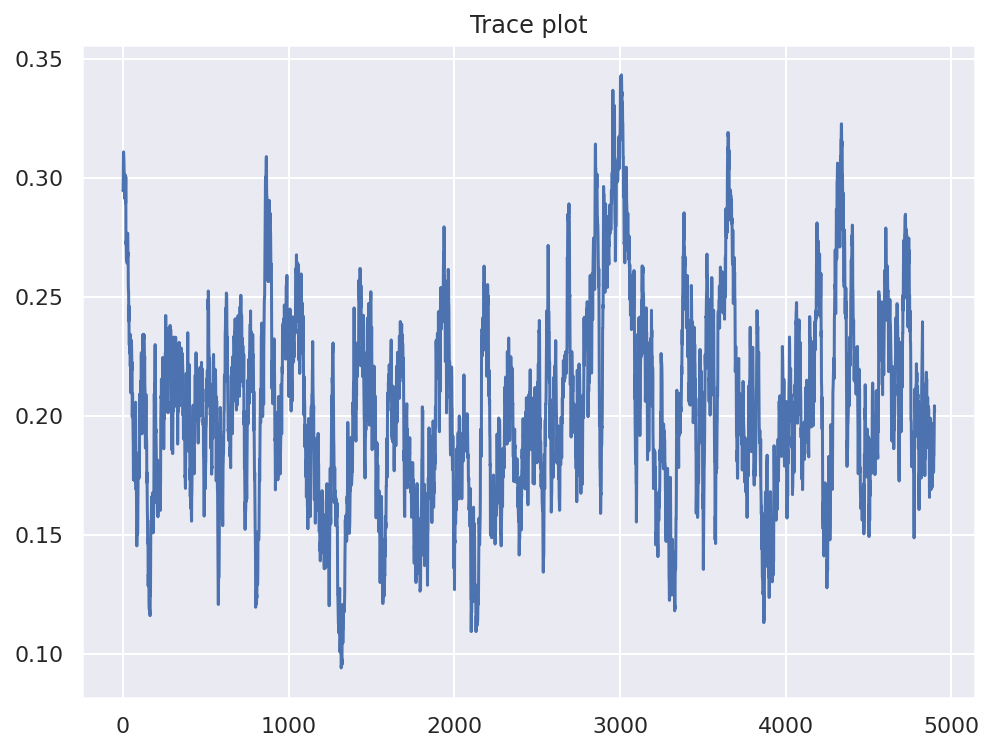

In [459]:
fig = plt.figure(figsize=(8, 6))
plt.plot(trace)
plt.title('Trace plot')
plt.show()

Другой более детальный пример: https://twiecki.io/blog/2015/11/10/mcmc-sampling/